In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.0 MB/s eta 0:00:00a 0:00:01


In [ ]:
!pip install -U --no-cache-dir numpy==1.26.4 scipy==1.11.4 scikit-learn==1.3.2


In [2]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
dataset_path = "/kaggle/input/ham10000-imagenet-style-dataset"
base_dir = "/kaggle/working/split_data"

# Selected ISIC classes
selected_classes = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

# Create split directories
for split in ['train', 'val', 'test']:
    for class_name in selected_classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Split data
for class_name in selected_classes:
    class_path = os.path.join(dataset_path, class_name)
    
    if not os.path.exists(class_path):
        print(f"Skipping missing class: {class_name}")
        continue

    images = os.listdir(class_path)

    train_files, temp_files = train_test_split(
        images, test_size=0.3, random_state=42
    )
    val_files, test_files = train_test_split(
        temp_files, test_size=0.5, random_state=42
    )

    for file in train_files:
        shutil.copy(
            os.path.join(class_path, file),
            os.path.join(base_dir, 'train', class_name, file)
        )

    for file in val_files:
        shutil.copy(
            os.path.join(class_path, file),
            os.path.join(base_dir, 'val', class_name, file)
        )

    for file in test_files:
        shutil.copy(
            os.path.join(class_path, file),
            os.path.join(base_dir, 'test', class_name, file)
        )

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),  # recommended for MobileNetV2
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

2026-02-02 17:31:40.462984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770053500.670264      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770053500.725984      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770053501.199529      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770053501.199587      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770053501.199590      55 computation_placer.cc:177] computation placer alr

Found 7007 images belonging to 7 classes.
Found 1502 images belonging to 7 classes.
Found 1506 images belonging to 7 classes.


In [3]:
def print_class_distribution(base_dir, splits, classes):
    for split in splits:
        print(f"\n{split.upper()} SET")
        print("-" * 30)
        total = 0
        for cls in classes:
            cls_path = os.path.join(base_dir, split, cls)
            count = len(os.listdir(cls_path)) if os.path.exists(cls_path) else 0
            total += count
            print(f"{cls:5s}: {count}")
        print(f"Total: {total}")

splits = ['train', 'val', 'test']
print_class_distribution(base_dir, splits, selected_classes)



TRAIN SET
------------------------------
akiec: 228
bcc  : 359
bkl  : 769
df   : 80
mel  : 779
nv   : 4693
vasc : 99
Total: 7007

VAL SET
------------------------------
akiec: 49
bcc  : 77
bkl  : 165
df   : 17
mel  : 167
nv   : 1006
vasc : 21
Total: 1502

TEST SET
------------------------------
akiec: 50
bcc  : 78
bkl  : 165
df   : 18
mel  : 167
nv   : 1006
vasc : 22
Total: 1506


In [ ]:
import os
import random
import shutil

base_path = "/kaggle/working/split_data"
splits = [""]   # balance ONLY train set
TARGET_PER_CLASS = 2000

for split in splits:
    split_path = os.path.join(base_path, split)

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        images = os.listdir(cls_path)

        # Downsample (nv will hit this)
        if len(images) > TARGET_PER_CLASS:
            remove_count = len(images) - TARGET_PER_CLASS
            remove_imgs = random.sample(images, remove_count)
            for img in remove_imgs:
                os.remove(os.path.join(cls_path, img))

        # Oversample (minority classes)
        elif len(images) < TARGET_PER_CLASS:
            add_count = TARGET_PER_CLASS - len(images)
            for i in range(add_count):
                src_img = random.choice(images)
                src_path = os.path.join(cls_path, src_img)
                new_name = f"aug_{i}_{src_img}"
                dst_path = os.path.join(cls_path, new_name)
                shutil.copy(src_path, dst_path)
for split in ["train", "val", "test"]:
    split_path = os.path.join(base_path, split)
    if os.path.exists(split_path):
        print(f"\n{split.upper()} distribution:")
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            print(f"{cls}: {len(os.listdir(cls_path))}")


In [3]:
!pip install qiskit-machine-learning==0.8.3 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 37.7 MB/s eta 0:00:00:00:010:01m


In [ ]:
# =========================================================
# Full Integrated Script: MobileNetV3-Large + YOLOv11x + LNN Stacking Ensemble
# =========================================================

import os
import numpy as np
from tqdm import tqdm
import json

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

from ultralytics import YOLO
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN

from sklearn.metrics import accuracy_score, confusion_matrix

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Dataset & Transforms
# -------------------------------
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# MobileNet transforms (224)
train_transform_mb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.4), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])
val_test_transform_mb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# YOLO transforms (448)
train_transform_yolo = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(448, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])
val_test_transform_yolo = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Dataset paths
DATA_ROOT = "/kaggle/working/split_data"
train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")

train_dataset_mb = datasets.ImageFolder(train_dir, transform=train_transform_mb)
val_dataset_mb   = datasets.ImageFolder(val_dir, transform=val_test_transform_mb)
test_dataset_mb  = datasets.ImageFolder(test_dir, transform=val_test_transform_mb)

train_dataset_yolo = datasets.ImageFolder(train_dir, transform=train_transform_yolo)
val_dataset_yolo   = datasets.ImageFolder(val_dir, transform=val_test_transform_yolo)
test_dataset_yolo  = datasets.ImageFolder(test_dir, transform=val_test_transform_yolo)

num_classes = len(train_dataset_mb.classes)
class_names = train_dataset_mb.classes
print(f"Num classes detected: {num_classes}")

batch_size = 32
num_workers = min(8, (os.cpu_count() or 4))

train_loader_mb = DataLoader(train_dataset_mb, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader_mb = DataLoader(val_dataset_mb, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader_mb = DataLoader(test_dataset_mb, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

train_loader_yolo = DataLoader(train_dataset_yolo, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader_yolo = DataLoader(val_dataset_yolo, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader_yolo = DataLoader(test_dataset_yolo, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# -------------------------------
# Initialize metric storage
# -------------------------------
training_logs = {
    "mobilenet": [],
    "yolo": [],
    "lnn_meta_nn": []
}

# ========================================================
# 1) MobileNetV3-Large Training
# ========================================================
print("\n=== MobileNetV3-Large training ===")
mobilenet = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
mobilenet.classifier[-1] = nn.Linear(1280, num_classes)
mobilenet = mobilenet.to(device)

for param in mobilenet.features.parameters():
    param.requires_grad = False
for param in mobilenet.classifier.parameters():
    param.requires_grad = True

optimizer_mb = AdamW(filter(lambda p: p.requires_grad, mobilenet.parameters()), lr=1e-4, weight_decay=1e-4)
criterion_mb = nn.CrossEntropyLoss(label_smoothing=0.0)
scaler_mb = GradScaler()

head_epochs = 5
total_epochs_mb = 100
scheduler_mb = OneCycleLR(optimizer_mb, max_lr=1e-3, steps_per_epoch=len(train_loader_mb), epochs=head_epochs, pct_start=0.3, div_factor=25, final_div_factor=1000)

best_val_acc_mb = 0.0
patience_mb = 8
patience_counter_mb = 0

for epoch in range(total_epochs_mb):
    if epoch == head_epochs:
        print("Unfreezing all MobileNet layers for full fine-tuning.")
        for param in mobilenet.parameters():
            param.requires_grad = True
        optimizer_mb = AdamW(mobilenet.parameters(), lr=1e-5, weight_decay=1e-4)
        scheduler_mb = OneCycleLR(optimizer_mb, max_lr=5e-4, steps_per_epoch=len(train_loader_mb), epochs=(total_epochs_mb - head_epochs), pct_start=0.3, div_factor=25, final_div_factor=1000)

    mobilenet.train()
    running_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in tqdm(train_loader_mb, desc=f"MobileNet Epoch {epoch+1}/{total_epochs_mb} [Training]"):
        images, labels = images.to(device), labels.to(device)
        optimizer_mb.zero_grad()
        with autocast():
            outputs = mobilenet(images)
            loss = criterion_mb(outputs, labels)
        scaler_mb.scale(loss).backward()
        scaler_mb.step(optimizer_mb)
        scaler_mb.update()
        scheduler_mb.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader_mb)
    train_acc = 100 * train_correct / train_total

    # Validation
    mobilenet.eval()
    val_correct, val_total, val_loss_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader_mb:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = mobilenet(images)
                v_loss = criterion_mb(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss_total += v_loss.item()
    avg_val_loss = val_loss_total / len(val_loader_mb)
    val_acc = 100 * val_correct / val_total

    training_logs["mobilenet"].append({"epoch": epoch+1, "train_loss": avg_train_loss, "train_acc": train_acc, "val_loss": avg_val_loss, "val_acc": val_acc})

    if val_acc > best_val_acc_mb:
        best_val_acc_mb = val_acc
        patience_counter_mb = 0
        torch.save(mobilenet.state_dict(), "best_mobilenet.pth")
    else:
        patience_counter_mb += 1
        if patience_counter_mb >= patience_mb:
            print("⏹️ Early stopping MobileNet triggered!")
            break


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda
Num classes detected: 7

=== MobileNetV3-Large training ===
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 143MB/s]
/tmp/ipykernel_55/1176650483.py:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_mb = GradScaler()
MobileNet Epoch 1/100 [Training]:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_55/1176650483.py:150: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
MobileNet Epoch 1/100 [Training]: 100%|██████████| 219/219 [00:41<00:00,  5.24it/s]
/tmp/ipykernel_55/1176650483.py:171: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
MobileNet Epoch 5/100 [Training]: 100%|██████████| 219/219 [00:40<00:00,  5.43it/s]


Unfreezing all MobileNet layers for full fine-tuning.


MobileNet Epoch 31/100 [Training]: 100%|██████████| 219/219 [00:43<00:00,  5.06it/s]


⏹️ Early stopping MobileNet triggered!


In [ ]:
# ========================================================
# 2) YOLOv8 Training with DeepCustomHead + Quantum Regularization
# ========================================================
print("\n=== YOLOv11 training with quantum regularization ===")
yolo_wrapper = YOLO("yolo11x-cls.pt")  # placeholder
old_head = yolo_wrapper.model.model[-1]
in_features = old_head.linear.in_features if hasattr(old_head, "linear") and isinstance(old_head.linear, nn.Linear) else old_head.in_channels

class DeepCustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.act1 = nn.SiLU()
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.act2 = nn.SiLU()
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.act3 = nn.SiLU()
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.act4 = nn.SiLU()
        self.drop4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.act5 = nn.SiLU()
        self.drop5 = nn.Dropout(0.6)
        self.fc6 = nn.Linear(256, num_classes)
        self.se = nn.Sequential(nn.Linear(256, 64), nn.ReLU(), nn.Linear(64, 256), nn.Sigmoid())

    def forward(self, x):
        x = self.drop1(self.act1(self.bn1(self.fc1(x))))
        x = self.drop2(self.act2(self.bn2(self.fc2(x))))
        x = self.drop3(self.act3(self.bn3(self.fc3(x))))
        x = self.drop4(self.act4(self.bn4(self.fc4(x))))
        x = self.drop5(self.act5(self.bn5(self.fc5(x))))
        se_weight = self.se(x)
        x = x * se_weight
        return self.fc6(x)

yolo_wrapper.model.model[-1].linear = DeepCustomHead(in_features, num_classes)
for param in yolo_wrapper.model.model[:-5].parameters():
    param.requires_grad = False
for param in yolo_wrapper.model.model[-5:].parameters():
    param.requires_grad = True

# =========================================================
# Quantum Neural Network Setup for YOLOv8 Head
# =========================================================

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Number of qubits for the QNN
n_qubits = 4

# Feature map for encoding classical inputs
feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)

# Ansatz (trainable quantum circuit)
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2)

# Compose the full quantum circuit
qc = QuantumCircuit(n_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Create an Estimator primitive
estimator = Estimator()

# Define input and weight parameters
input_params = list(feature_map.parameters)
weight_params = list(ansatz.parameters)

# Instantiate the QNN using keyword arguments (fixes previous TypeError)
qnn = EstimatorQNN(
    circuit=qc,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator
)


def quantum_regularization(predictions, lambda_q=0.05):
    batch_features = predictions.mean(dim=0)[:n_qubits]
    inputs = batch_features.detach().cpu().numpy().reshape(1, -1)
    q_weights = np.random.uniform(0, 2 * np.pi, len(qnn.weight_params))
    q_out = qnn.forward(inputs, q_weights)
    q_var = np.var(q_out)
    return torch.tensor(lambda_q * q_var, dtype=torch.float32, device=predictions.device)

model_yolo = yolo_wrapper.model.to(device)
optimizer_yolo = AdamW(model_yolo.parameters(), lr=1e-4, weight_decay=1e-3)
criterion_yolo = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler_yolo = ReduceLROnPlateau(
    optimizer_yolo,
    mode='max',
    factor=0.5,
    patience=2
)

best_val_acc_yolo = 0.0
patience_yolo = 7
patience_counter_yolo = 0
total_epochs_yolo = 100

for epoch in range(total_epochs_yolo):
    model_yolo.train()
    running_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in tqdm(train_loader_yolo, desc=f"YOLO Epoch {epoch+1}/{total_epochs_yolo} [Training]"):
        images, labels = images.to(device), labels.to(device)
        optimizer_yolo.zero_grad()
        outputs = model_yolo(images)
        outputs = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
        loss = criterion_yolo(outputs, labels) + quantum_regularization(outputs)
        loss.backward()
        optimizer_yolo.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader_yolo)
    train_acc = 100 * train_correct / train_total

    # Validation
    model_yolo.eval()
    val_correct, val_total, val_loss_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader_yolo:
            images, labels = images.to(device), labels.to(device)
            outputs = model_yolo(images)
            outputs = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
            v_loss = criterion_yolo(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss_total += v_loss.item()
    avg_val_loss = val_loss_total / len(val_loader_yolo)
    val_acc = 100 * val_correct / val_total

    training_logs["yolo"].append({"epoch": epoch+1, "train_loss": avg_train_loss, "train_acc": train_acc, "val_loss": avg_val_loss, "val_acc": val_acc})
    scheduler_yolo.step(val_acc)

    if val_acc > best_val_acc_yolo:
        best_val_acc_yolo = val_acc
        patience_counter_yolo = 0
        torch.save(model_yolo.state_dict(), "best_yolo.pth")
    else:
        patience_counter_yolo += 1
        if patience_counter_yolo >= patience_yolo:
            print("⏹️ Early stopping YOLO triggered!")
            break

# ========================================================
# 3) Generate Meta-Features for LNN Stacking
# ========================================================
mobilenet.load_state_dict(torch.load("best_mobilenet.pth", map_location=device))
model_yolo.load_state_dict(torch.load("best_yolo.pth", map_location=device))
meta_features, meta_labels = [], []

mobilenet.eval()
model_yolo.eval()

with torch.no_grad():
    for (imgs_mb, labels), (imgs_yolo, _) in zip(val_loader_mb, val_loader_yolo):
        imgs_mb = imgs_mb.to(device)
        imgs_yolo = imgs_yolo.to(device)

        logits_mb = mobilenet(imgs_mb)
        logits_yolo = model_yolo(imgs_yolo)
        logits_yolo = logits_yolo[0] if isinstance(logits_yolo, (list, tuple)) else logits_yolo

        features = torch.cat([logits_mb, logits_yolo], dim=1)

        meta_features.append(features.cpu())
        meta_labels.append(labels.cpu())

meta_X = torch.cat(meta_features)
meta_y = torch.cat(meta_labels)


meta_features = np.vstack(meta_features)
meta_labels = np.hstack(meta_labels)

# ========================================================
# 4) LNN Meta-Classifier
# ========================================================
print("\n=== Training LNN Meta-Classifier ===")
class LiquidNeuronCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau_p = nn.Parameter(torch.Tensor(hidden_size))
        self.A = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bias = nn.Parameter(torch.Tensor(hidden_size))
        nn.init.uniform_(self.tau_p, 0.0, 1.0)
        nn.init.xavier_uniform_(self.A)
        nn.init.xavier_uniform_(self.W)
        nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, x, h_state, delta_t=0.1):
        tau = torch.exp(self.tau_p)
        f = torch.tanh(torch.matmul(x, self.A) + torch.matmul(h_state, self.W) + self.bias)
        next_h_state = h_state + (delta_t / tau) * (-h_state + f)
        return next_h_state

class CustomLNNMetaModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size):
        super().__init__()
        self.lnn_cell = LiquidNeuronCell(input_dim, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_dim)
        self.hidden_size = hidden_size
    def forward(self, x):
        h_state = torch.zeros(x.size(0), self.hidden_size, device=x.device)
        h_state = self.lnn_cell(x, h_state)
        return self.output_layer(h_state)

meta_X = torch.tensor(meta_features, dtype=torch.float32).to(device)
meta_y = torch.tensor(meta_labels, dtype=torch.long).to(device)

lnn_meta_model = CustomLNNMetaModel(meta_features.shape[1], num_classes, hidden_size=128).to(device)
criterion_lnn = nn.CrossEntropyLoss()
optimizer_lnn = torch.optim.Adam(lnn_meta_model.parameters(), lr=1e-4)

meta_dataset = TensorDataset(meta_X, meta_y)
meta_loader = DataLoader(meta_dataset, batch_size=16, shuffle=True)
epochs_lnn = 300

for epoch in range(epochs_lnn):
    lnn_meta_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch_X, batch_y in meta_loader:
        optimizer_lnn.zero_grad()
        outputs = lnn_meta_model(batch_X)
        loss = criterion_lnn(outputs, batch_y)
        loss.backward()
        optimizer_lnn.step()
        running_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    avg_train_loss = running_loss / total
    train_acc = 100 * correct / total
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"LNN Epoch [{epoch+1}/{epochs_lnn}] Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}%")
    training_logs["lnn_meta_nn"].append({"epoch": epoch+1, "train_loss": avg_train_loss, "train_acc": train_acc})

# ========================================================
# 5) Final Ensemble Evaluation
# ========================================================
test_meta_features, test_meta_labels = [], []

mobilenet.eval()
model_yolo.eval()

with torch.no_grad():
    for (imgs_mb, labels), (imgs_yolo, _) in zip(test_loader_mb, test_loader_yolo):
        imgs_mb = imgs_mb.to(device)
        imgs_yolo = imgs_yolo.to(device)

        logits_mb = mobilenet(imgs_mb)
        logits_yolo = model_yolo(imgs_yolo)
        logits_yolo = logits_yolo[0] if isinstance(logits_yolo, (list, tuple)) else logits_yolo

        features = torch.cat([logits_mb, logits_yolo], dim=1)

        test_meta_features.append(features.cpu())
        test_meta_labels.append(labels.cpu())

test_X = torch.cat(test_meta_features).to(device)
test_y = torch.cat(test_meta_labels).to(device)

lnn_meta_model.eval()
with torch.no_grad():
    outputs = lnn_meta_model(test_X)
    _, predicted_classes = torch.max(outputs, 1)

final_accuracy = accuracy_score(test_y.cpu().numpy(),
                                predicted_classes.cpu().numpy())
final_conf_matrix = confusion_matrix(test_y.cpu().numpy(),predicted_classes.cpu().numpy())

print("\n=== Final Ensemble Evaluation ===")
print(f"Stacking Ensemble (LNN) Accuracy: {final_accuracy*100:.2f}%")
print("Confusion Matrix:")
print(final_conf_matrix)

# ========================================================
# 6) Save all metrics
# ========================================================
with open("training_metrics.json", "w") as f:
    json.dump(training_logs, f, indent=4)
print("\nTraining and ensemble metrics saved to 'training_metrics.json'")



=== YOLOv11 training with quantum regularization ===


/tmp/ipykernel_55/3486333211.py:75: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/tmp/ipykernel_55/3486333211.py:82: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
YOLO Epoch 39/100 [Training]: 100%|██████████| 219/219 [01:34<00:00,  2.31it/s]


⏹️ Early stopping YOLO triggered!

=== Training LNN Meta-Classifier ===
LNN Epoch [1/300] Loss: 1.9609, Acc: 2.46%
LNN Epoch [50/300] Loss: 0.5321, Acc: 84.29%
LNN Epoch [100/300] Loss: 0.3767, Acc: 88.75%
LNN Epoch [150/300] Loss: 0.3381, Acc: 89.28%
LNN Epoch [200/300] Loss: 0.3227, Acc: 89.95%
LNN Epoch [250/300] Loss: 0.3130, Acc: 89.81%
LNN Epoch [300/300] Loss: 0.3054, Acc: 90.21%

=== Final Ensemble Evaluation ===
Stacking Ensemble (LNN) Accuracy: 87.98%
Confusion Matrix:
[[ 29   1  12   0   6   2   0]
 [  4  64   4   0   1   5   0]
 [  8   2 135   0   5  15   0]
 [  2   0   1  11   1   3   0]
 [  1   1  13   0 112  38   2]
 [  1   3  21   1  22 957   1]
 [  0   0   0   0   2   3  17]]

Training and ensemble metrics saved to 'training_metrics.json'


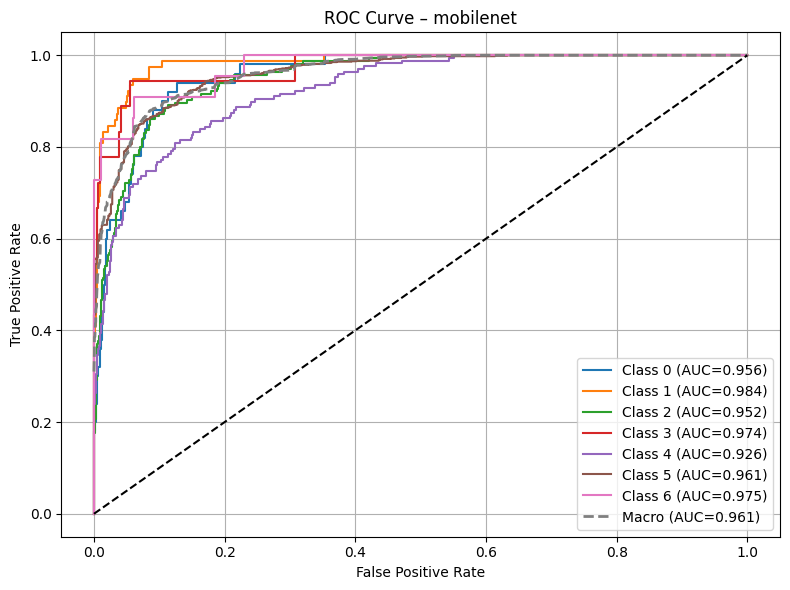


=== MOBILENET ===
Accuracy        : 84.33%
Precision (Mac) : 0.7649
Recall (Mac)    : 0.6363
F1 (Macro)     : 0.6774
F1 (Weighted)  : 0.8388
Inference Time : 5.380s
Avg / Sample   : 3.573 ms


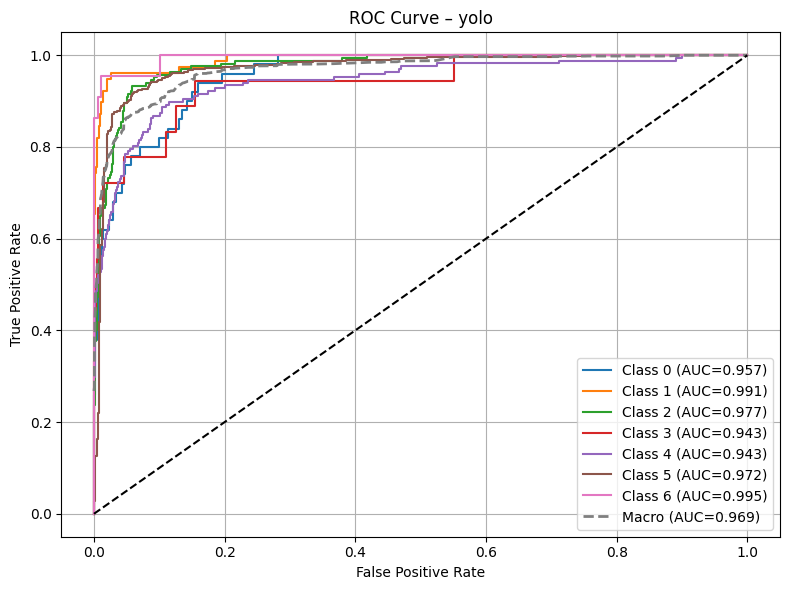


=== YOLO ===
Accuracy        : 87.32%
Precision (Mac) : 0.7896
Recall (Mac)    : 0.7414
F1 (Macro)     : 0.7587
F1 (Weighted)  : 0.8739
Inference Time : 13.546s
Avg / Sample   : 8.994 ms


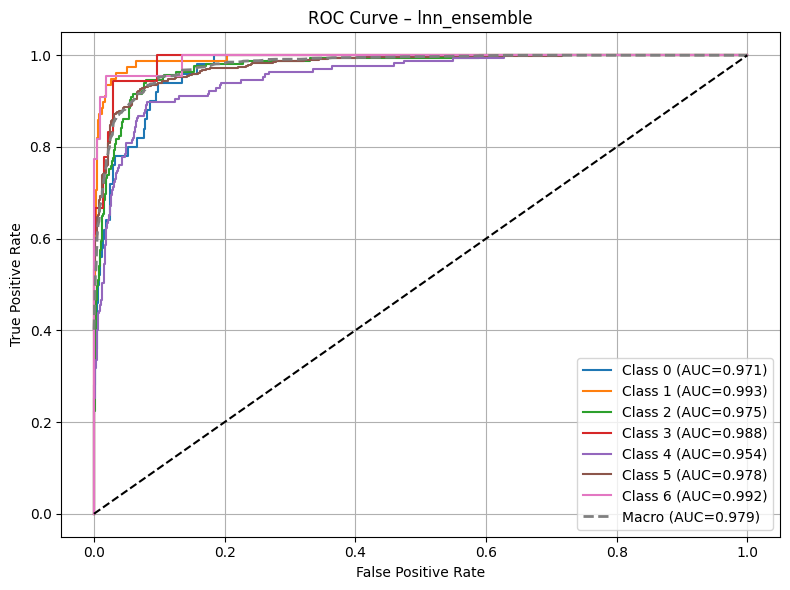


=== LNN_ENSEMBLE ===
Accuracy        : 87.98%
Precision (Mac) : 0.8179
Recall (Mac)    : 0.7464
F1 (Macro)     : 0.7763
F1 (Weighted)  : 0.8784
Inference Time : 0.043s
Avg / Sample   : 0.029 ms

✅ All evaluation metrics and ROC data saved successfully


In [7]:
# ========================================================
# FINAL FULL EVALUATION: ROC + METRICS + INFERENCE TIME
# ========================================================

import time
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset


def evaluate_model_full(
    model,
    dataloader,
    num_classes,
    device,
    model_name,
    save_prefix="eval"
):
    model.eval()

    all_logits = []
    all_labels = []

    # ---------------- Inference Timing ----------------
    start_time = time.perf_counter()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
            all_logits.append(outputs.cpu())
            all_labels.append(labels.cpu())
    end_time = time.perf_counter()

    inference_time = end_time - start_time
    avg_time_per_sample = inference_time / len(dataloader.dataset)

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)

    probs = torch.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    labels_np = labels.numpy()

    # ---------------- Metrics ----------------
    metrics = {
        "accuracy": accuracy_score(labels_np, preds),
        "precision_macro": precision_score(labels_np, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels_np, preds, average="macro", zero_division=0),
        "f1_macro": f1_score(labels_np, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels_np, preds, average="weighted", zero_division=0),
        "inference_time_sec": inference_time,
        "avg_time_per_sample_sec": avg_time_per_sample
    }

    # ---------------- ROC ----------------
    labels_bin = label_binarize(labels_np, classes=list(range(num_classes)))
    roc_data = {}

    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        roc_data[f"class_{i}"] = {
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": roc_auc
        }
        plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.3f})")

    # -------- Macro ROC --------
    all_fpr = np.unique(np.concatenate([
        roc_data[f"class_{i}"]["fpr"] for i in range(num_classes)
    ]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(num_classes):
        mean_tpr += np.interp(
            all_fpr,
            roc_data[f"class_{i}"]["fpr"],
            roc_data[f"class_{i}"]["tpr"]
        )

    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    roc_data["macro"] = {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }

    plt.plot(
        all_fpr,
        mean_tpr,
        linestyle="--",
        linewidth=2,
        label=f"Macro (AUC={macro_auc:.3f})"
    )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"{save_prefix}_{model_name}_roc.png", dpi=300)
    plt.show()

    with open(f"{save_prefix}_{model_name}_roc.json", "w") as f:
        json.dump(roc_data, f, indent=4)

    print(f"\n=== {model_name.upper()} ===")
    print(f"Accuracy        : {metrics['accuracy']*100:.2f}%")
    print(f"Precision (Mac) : {metrics['precision_macro']:.4f}")
    print(f"Recall (Mac)    : {metrics['recall_macro']:.4f}")
    print(f"F1 (Macro)     : {metrics['f1_macro']:.4f}")
    print(f"F1 (Weighted)  : {metrics['f1_weighted']:.4f}")
    print(f"Inference Time : {metrics['inference_time_sec']:.3f}s")
    print(f"Avg / Sample   : {metrics['avg_time_per_sample_sec']*1000:.3f} ms")

    return metrics


# ========================================================
# RUN EVALUATION
# ========================================================

mobilenet_metrics = evaluate_model_full(
    model=mobilenet,
    dataloader=test_loader_mb,
    num_classes=num_classes,
    device=device,
    model_name="mobilenet"
)

yolo_metrics = evaluate_model_full(
    model=model_yolo,
    dataloader=test_loader_yolo,
    num_classes=num_classes,
    device=device,
    model_name="yolo"
)

lnn_metrics = evaluate_model_full(
    model=lnn_meta_model,
    dataloader=DataLoader(
        TensorDataset(test_X, test_y),
        batch_size=32,
        shuffle=False
    ),
    num_classes=num_classes,
    device=device,
    model_name="lnn_ensemble"
)

# ========================================================
# SAVE ALL METRICS
# ========================================================

all_metrics = {
    "mobilenet": mobilenet_metrics,
    "yolo": yolo_metrics,
    "lnn_ensemble": lnn_metrics
}

with open("final_evaluation_metrics.json", "w") as f:
    json.dump(all_metrics, f, indent=4)

print("\n✅ All evaluation metrics and ROC data saved successfully")
